# Description

In this notebook, I will train the Sentiment140 dataset on CENTRALIZED LEARNING.

In [15]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
import pandas as  pd
import re
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
tf.random.set_seed(42)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:  tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e: print(e)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input,Flatten,Embedding, Dropout,Conv1D,MaxPooling1D, Dense, GlobalMaxPooling1D,BatchNormalization,\
                                    Add,GlobalAveragePooling1D, Activation
from tensorflow.keras.models import Model

# 1. Dataset

## 1.1. Load dataset

In [5]:
PATH_DATASET = r"data/sentiment140.csv"
COLUMN_NAMES = ['target', 'ids', 'date', 'flag', 'client', 'text']
N_SAMPLES = 500_000

In [6]:
def remove_stopwords(sentence):
    STOP_WORDS = set(nltk.corpus.stopwords.words('english'))
    final_sentence=[]
    for word in sentence.split():
        if word not in STOP_WORDS:
            final_sentence.append(word)
    return final_sentence

def clean_sentence(sentence):
    sentence = re.sub(r"https?://\S+|www\.\S+"," ",sentence) #for urls
    sentence = re.sub(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});"," ",sentence) #html tags
    sentence = re.sub(r"[^\w\s]", " ", sentence) # Removing the Punctuation
    sentence = re.sub(r"\w*\d\w*", " ", sentence) # Removing words that have numbers
    sentence = re.sub(r"[0-9]+", " ", sentence) # Removing Digits
    sentence = re.sub(r"\s+", " ", sentence).strip() # Cleaning white spaces
    sentence = sentence.lower()
    # sentence = remove_stopwords(sentence)
    return sentence

def find_rare_word(X, frequency_threshold = 1):
    all_words = [word for sentence in X for word in sentence.split()]
    word_counts = Counter(all_words)
    rare_words = {word for word, count in word_counts.items() if count <= frequency_threshold}
    return rare_words

def remove_rare_words(sentence, list_rare_words):
    """
    This function remove rare words from a sentence
    """
    return ' '.join([word for word in word_tokenize(sentence.lower()) if word not in list_rare_words])

In [7]:
df = pd.read_csv(PATH_DATASET,  encoding='latin1', header=None)
df.columns = COLUMN_NAMES

if N_SAMPLES != None:
    df = df.sample(N_SAMPLES)

df['target'] = df['target'].replace(4, 1)

print(f"Shape of df: {df.shape}")
df.head()

Shape of df: (500000, 6)


,target,ids,date,flag,client,text
629785,0,2231763724,Thu Jun 18 19:00:00 PDT 2009,NO_QUERY,TaylorT21,went to the doctor... on vicodin and crutches....
22208,0,1557438847,Sun Apr 19 04:07:10 PDT 2009,NO_QUERY,TheFirstChibi,@fiofo Hahaha yeah. Awww I miss him on the show
1358092,1,2048139455,Fri Jun 05 14:43:26 PDT 2009,NO_QUERY,mariaporter,"@PainterMommy LOL, better than being sick, fai..."
1385026,1,2052710996,Sat Jun 06 01:43:31 PDT 2009,NO_QUERY,ma163,http://twitpic.com/6qe0y - My lil one wants to...
1579894,1,2189997489,Tue Jun 16 01:28:43 PDT 2009,NO_QUERY,huedo,@valencini but my class got a week's extension...


In [8]:
# Clean data frame
df['text'] = df['text'].apply(clean_sentence)

# Remove empty rows
df = df[df['text'] != '']

# Remove rows with too short text
df = df[df['text'].apply(len) > 5]

print(f"Shape of df: {df.shape}")
df.head()

Shape of df: (499455, 6)


,target,ids,date,flag,client,text
629785,0,2231763724,Thu Jun 18 19:00:00 PDT 2009,NO_QUERY,TaylorT21,went to the doctor on vicodin and crutches yay me
22208,0,1557438847,Sun Apr 19 04:07:10 PDT 2009,NO_QUERY,TheFirstChibi,fiofo hahaha yeah awww i miss him on the show
1358092,1,2048139455,Fri Jun 05 14:43:26 PDT 2009,NO_QUERY,mariaporter,paintermommy lol better than being sick fainty...
1385026,1,2052710996,Sat Jun 06 01:43:31 PDT 2009,NO_QUERY,ma163,my lil one wants to snuggle
1579894,1,2189997489,Tue Jun 16 01:28:43 PDT 2009,NO_QUERY,huedo,valencini but my class got a week s extension ...


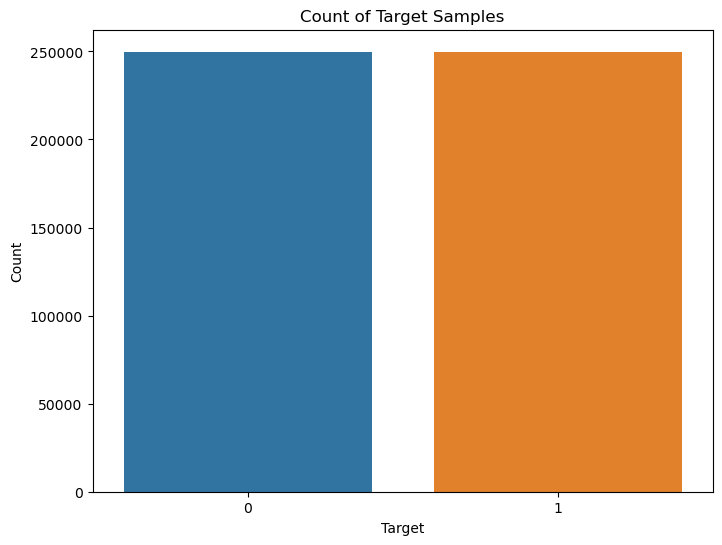

In [9]:
plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=df)
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Count of Target Samples')
plt.show()

## 1.2. Load pre-train GloVe Embedding

In [10]:
# Load pre-trained Word2Vec model
def load_glove_embeddings(file_path):
    """Load GloVe embeddings from file."""
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

glove_file_path = 'models/glove.6B.50d.txt'
glove_embeddings = load_glove_embeddings(glove_file_path)

## 1.3. Process data

In [11]:
# Extract dataset
X = np.array(df['text'])
y = np.array(df['target'])

# list_rare_words = find_rare_word(X, frequency_threshold=1)
# print(f"Number of rare words: {len(list_rare_words)}")

# X = [remove_rare_words(sentence, list_rare_words) for sentence in X]
# X = np.array(X)
# print(f"[INFO] Remove rare words")

In [16]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")

Shape of X_train: (399564,)
Shape of X_test: (99891,)


In [17]:
max_sentence_length = 0
min_sentence_length = 1_000
list_vocab = set()

for sample in X_train: 
    sample = sample.split()
    if len(sample) > max_sentence_length:
        max_sentence_length = len(sample)
    if len(sample) < min_sentence_length:
        min_sentence_length = len(sample)
    for word in sample:
        list_vocab.add(word)

list_vocab = list(list_vocab)
print(f"Number of word in vocab: {len(list_vocab)}")
print(f"Max longest sentence: {max_sentence_length}")
print(f"Min shortest sentence: {min_sentence_length}")

Number of word in vocab: 220759
Max longest sentence: 116
Min shortest sentence: 1


In [18]:
# # Update token vocabulary.
# tokenizer = Tokenizer(num_words=len(list_vocab))
# tokenizer.fit_on_texts(X)
# print("[INFO] Done update vocabulary.")

# # Transform text to sequence of integer
# X_train = tokenizer.texts_to_sequences(X_train)
# X_test = tokenizer.texts_to_sequences(X_test)
# print("[INFO] Done transform text to integers.")

# # Padding sequence of integers.
# X_train = pad_sequences(X_train, maxlen=max_sentence_length, padding='post')
# X_test = pad_sequences(X_test, maxlen=max_sentence_length, padding='post')
# print("[INFO] Done padding.\n")

In [19]:
def Text_2_Vector(text, embeddings, max_sentence_length = 100, dims=50):
    """
    Convert text to vector using pre-trained GloVe embeddings.
    """

    vectors = np.zeros((max_sentence_length, dims), dtype=np.float32)

    list_words = text.split()
    for idx, word in enumerate(list_words):
        if idx >= max_sentence_length:
            break
        vectors[idx] = embeddings.get(word, np.zeros(dims)) 

    if len(vectors) == 0:   # If no word found in the GloVe embeddings, return a zero vector
        return np.zeros((max_sentence_length,dims))
    return np.array(vectors)

X_train = [Text_2_Vector(sample, glove_embeddings) for sample in X_train]
X_train = np.array(X_train)
X_test = [Text_2_Vector(sample, glove_embeddings) for sample in X_test]
X_test = np.array(X_test)

In [20]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")

X = y = None
df = None
gc.collect()

Shape of X_train: (399564, 100, 50)
Shape of X_test: (99891, 100, 50)


2683

# 2. Define model

In [21]:
def build_cnn_model(max_length, vocab_length, window=5, dim=10):
    INPUT = Input((max_length,))
    x = Embedding((vocab_length + 1), dim)(INPUT)
    x = Conv1D(32, window, activation='relu')(x)
    x = MaxPooling1D(3)(x)
    
    x = Conv1D(64, window, activation='relu')(x)
    x = MaxPooling1D(3)(x)
    
    x = Conv1D(128, window, activation='relu')(x)
    x = GlobalMaxPooling1D()(x)
    
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(INPUT, x)
    return model

def convolution_block(x, n_filters, filter_window, drop_out_rate=0.1):
    x = Conv1D(n_filters, filter_window)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(drop_out_rate)(x)
    x = MaxPooling1D(pool_size=3, strides=2)(x)
    return x


def build_cnn_model_without_embedding(filter_window=5, max_sentence_length = 100, dims=50):
    input_layer = Input((max_sentence_length,dims))
    x = convolution_block(input_layer, n_filters=32, filter_window=filter_window)
    x = convolution_block(x, n_filters=32, filter_window=filter_window)
    x = convolution_block(x, n_filters=64, filter_window=filter_window)
    x = convolution_block(x, n_filters=128, filter_window=filter_window)
    x = Flatten()(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(input_layer, x)
    return model

In [22]:
tf.keras.backend.clear_session()
model = build_cnn_model_without_embedding(filter_window=5, max_sentence_length=100, dims=50)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 50)]         0         
                                                                 
 conv1d (Conv1D)             (None, 96, 32)            8032      
                                                                 
 batch_normalization (Batch  (None, 96, 32)            128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 96, 32)            0         
                                                                 
 dropout (Dropout)           (None, 96, 32)            0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 47, 32)            0         
 D)                                                          

# 3. Training

In [23]:
BATCH_SIZE = 128
NUM_EPOCHS = 10

history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_split=0.2)

Epoch 1/10
2498/2498 [==============================] - 11s 3ms/step - loss: 0.5774 - accuracy: 0.6952 - val_loss: 0.5415 - val_accuracy: 0.7306
Epoch 2/10
2498/2498 [==============================] - 7s 3ms/step - loss: 0.5269 - accuracy: 0.7366 - val_loss: 0.5143 - val_accuracy: 0.7480
Epoch 3/10
2498/2498 [==============================] - 7s 3ms/step - loss: 0.5122 - accuracy: 0.7464 - val_loss: 0.5131 - val_accuracy: 0.7490
Epoch 4/10
2498/2498 [==============================] - 7s 3ms/step - loss: 0.5032 - accuracy: 0.7531 - val_loss: 0.5139 - val_accuracy: 0.7450
Epoch 5/10
2498/2498 [==============================] - 7s 3ms/step - loss: 0.4971 - accuracy: 0.7575 - val_loss: 0.5022 - val_accuracy: 0.7545
Epoch 6/10
2498/2498 [==============================] - 7s 3ms/step - loss: 0.4918 - accuracy: 0.7606 - val_loss: 0.4959 - val_accuracy: 0.7601
Epoch 7/10
2498/2498 [==============================] - 7s 3ms/step - loss: 0.4884 - accuracy: 0.7628 - val_loss: 0.4880 - val_accuracy

In [24]:
y_pred = model.predict(X_test)
y_pred = y_pred > 0.5

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print('Accuracy: %f' % accuracy)
print('Precision: %f' % precision)
print('Recall: %f' % recall)
print('F1 score: %f' % f1)

3122/3122 [==============================] - 2s 650us/step
Accuracy: 0.768197
Precision: 0.769352
Recall: 0.768185
F1 score: 0.767943
